# 06 — Deep Learning (ANN) for Credit Card Fraud Detection

## Objective
Build a minimal Artificial Neural Network (ANN) baseline for fraud detection using the preprocessed dataset.
This ANN is **not expected to beat** tree-based models (e.g., Random Forest / XGBoost), but it helps:
- demonstrate deep learning workflow,
- handle extreme class imbalance correctly,
- analyze training vs validation behavior,
- compare ANN limitations on tabular imbalanced data.

Dataset note: fraud rate is ~0.17% (highly imbalanced).


In [2]:
import sys
print(sys.version)


3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]


## Load Preprocessed Data

In this notebook, we directly use the preprocessed and transformed datasets generated in the previous steps of the project.

- All feature engineering and scaling have already been applied.
- Data is stored as NumPy arrays for efficient loading.
- Targets are reshaped into 1D arrays for compatibility with TensorFlow.

We load:
- Training set
- Validation set
- Test set


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [4]:
import numpy as np

# Load feature matrices
X_train = np.load("../data/processed/X_train_transformed.npy")
X_val   = np.load("../data/processed/X_val_transformed.npy")
X_test  = np.load("../data/processed/X_test_transformed.npy")

# Load labels
y_train = np.load("../data/processed/y_train.npy").ravel()
y_val   = np.load("../data/processed/y_val.npy").ravel()
y_test  = np.load("../data/processed/y_test.npy").ravel()

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (170883, 30) (170883,)
Validation set: (28481, 30) (28481,)
Test set: (85443, 30) (85443,)


## Class Imbalance Analysis

Credit card fraud detection is an extremely imbalanced classification problem.
In this dataset, fraudulent transactions represent a very small fraction of the total observations.

Using accuracy as a metric would be misleading.
Instead, we explicitly quantify the imbalance and compute class weights so that the neural network
pays more attention to the minority (fraud) class during training.

These class weights will be passed to the training procedure.


In [5]:
# Count class distribution in the training set
negatives = (y_train == 0).sum()
positives = (y_train == 1).sum()

fraud_ratio = positives / len(y_train)

print(f"Non-fraud transactions: {negatives}")
print(f"Fraud transactions: {positives}")
print(f"Fraud ratio: {fraud_ratio:.4%}")

# Compute class weights
class_weight = {
    0: 1.0,
    1: negatives / positives
}

print("Class weights:", class_weight)


Non-fraud transactions: 170588
Fraud transactions: 295
Fraud ratio: 0.1726%
Class weights: {0: 1.0, 1: np.float64(578.264406779661)}


## Artificial Neural Network (ANN) Architecture

We build a **minimal feedforward Artificial Neural Network** to serve as a deep learning baseline.

Design principles:
- Keep the architecture simple to avoid overfitting on highly imbalanced tabular data
- Use Batch Normalization to stabilize training
- Use Dropout for regularization
- Use a sigmoid output layer for binary classification

This ANN is **not expected to outperform tree-based models**, but it allows us to:
- demonstrate deep learning workflow,
- handle class imbalance correctly,
- analyze training vs validation behavior.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_ann(input_dim: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Build the model
model = build_ann(X_train.shape[1])

# Display model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 192 (768.00 B)

## Model Compilation

The ANN is compiled using:
- **Binary Cross-Entropy** loss for binary classification
- **Adam optimizer** with a standard learning rate
- **Imbalance-aware evaluation metrics**

Because the dataset is extremely imbalanced, accuracy is not used.
Instead, we monitor:
- **PR-AUC (Precision–Recall AUC)** → most informative for rare fraud detection
- **ROC-AUC** → included for comparison with previous models
- **Precision and Recall** → to analyze the trade-off explicitly

These metrics allow a fair comparison with classical machine learning models.


In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

print("Model compiled successfully.")


Model compiled successfully.


## Model Training

The ANN is trained using:
- **Class weights** to handle extreme class imbalance
- **Early stopping** to prevent overfitting
- **Validation PR-AUC** as the primary stopping criterion

Early stopping is critical in this context because:
- The number of fraud samples is very small
- Neural networks can easily overfit the majority class
- Validation performance is more informative than training loss

The best model (based on validation PR-AUC) is automatically restored.


In [9]:
# Callbacks to control training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_pr_auc",
        mode="max",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=2048,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 1.2898 - pr_auc: 0.1336 - precision: 0.0036 - recall: 0.8780 - roc_auc: 0.8719 - val_loss: 0.5847 - val_pr_auc: 0.5817 - val_precision: 0.0081 - val_recall: 0.9796 - val_roc_auc: 0.9795
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.6713 - pr_auc: 0.2372 - precision: 0.0071 - recall: 0.9356 - roc_auc: 0.9538 - val_loss: 0.3788 - val_pr_auc: 0.6377 - val_precision: 0.0285 - val_recall: 0.9796 - val_roc_auc: 0.9891
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5103 - pr_auc: 0.2797 - precision: 0.0127 - recall: 0.9424 - roc_auc: 0.9708 - val_loss: 0.2701 - val_pr_auc: 0.6252 - val_precision: 0.0443 - val_recall: 0.9592 - val_roc_auc: 0.9901
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.4273 - pr_auc: 0.3234 - precision: 0.0203 - recall: 0.9288 - roc_auc: 0.9747 - val_loss: 0.1996 - val_pr_auc: 0.6135 - val_precision: 0.0668 - val_recall: 0.9592 - val_roc_auc: 0.9899
Epoch 5/30
84/84 ━━

## Training vs Validation Analysis

To assess whether the ANN is overfitting or underfitting, we analyze
the evolution of training and validation metrics across epochs.

We focus primarily on:
- **PR-AUC (Precision–Recall AUC)**, which is the most informative metric
  for highly imbalanced fraud detection problems.
- Secondary metrics such as ROC-AUC, Precision, and Recall are used
  to support interpretation.

Early stopping selected the model from the epoch with the highest
validation PR-AUC, helping prevent overfitting.


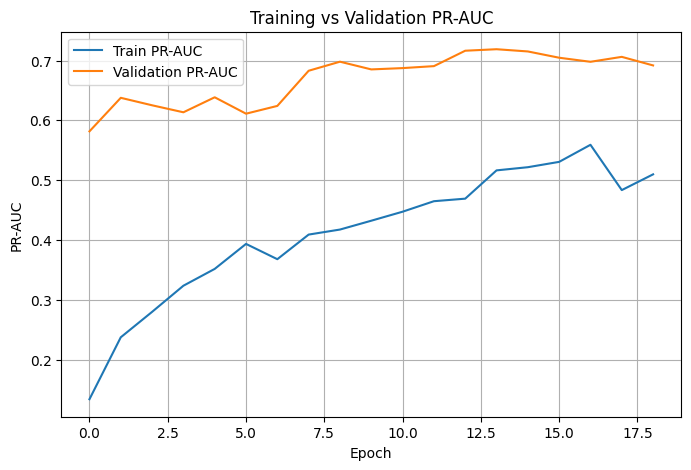

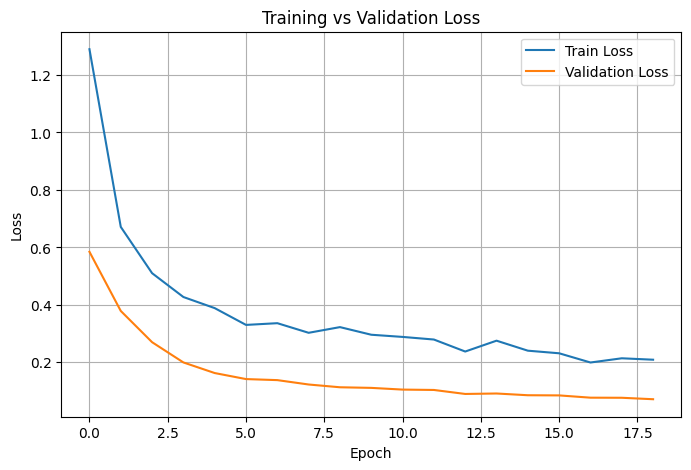

In [10]:
import matplotlib.pyplot as plt

# Plot PR-AUC
plt.figure(figsize=(8, 5))
plt.plot(history.history["pr_auc"], label="Train PR-AUC")
plt.plot(history.history["val_pr_auc"], label="Validation PR-AUC")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.title("Training vs Validation PR-AUC")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Test Set Evaluation (Probability-Based Metrics)

After training and selecting the best model using the validation set,
we evaluate the ANN on the **held-out test set**.

Because fraud detection is a highly imbalanced problem:
- We evaluate the model using **probability-based metrics**
- We do **not** rely on accuracy or a fixed decision threshold at this stage

Reported metrics:
- **ROC-AUC**: measures ranking quality across all thresholds
- **PR-AUC (Average Precision)**: most informative metric for rare fraud detection

These metrics allow a fair comparison with classical machine learning models.


In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Predict probabilities on the test set
y_test_proba = model.predict(X_test).ravel()

# Compute probability-based metrics
roc_auc = roc_auc_score(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Test PR-AUC : {pr_auc:.4f}")


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Test ROC-AUC: 0.9746
Test PR-AUC : 0.6886


## Decision Threshold Optimization

The ANN outputs probabilities, not class labels.
Using a default threshold of 0.5 is often **suboptimal** for highly imbalanced problems.

To obtain a more meaningful classification:
- We tune the decision threshold using the **validation set**
- The objective is to balance **precision and recall**
- We select the threshold that maximizes the **F1-score**

This step is critical for fraud detection systems, where the choice of threshold
directly impacts business cost and investigation workload.


In [12]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Predict probabilities on validation set
y_val_proba = model.predict(X_val).ravel()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Compute F1-score for each threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-12)

# Ignore last point (no threshold)
best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best validation threshold: {best_threshold:.6f}")
print(f"Best validation F1-score: {best_f1:.4f}")


891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Best validation threshold: 0.996703
Best validation F1-score: 0.8200


## Final Test Evaluation (Tuned Threshold)

Using the optimized decision threshold obtained from the validation set,
we now evaluate the ANN on the **test set**.

This evaluation reflects a **realistic deployment scenario**, where:
- Probabilities are converted into class labels
- A conservative threshold is used to limit false positives
- Precision–recall trade-offs are explicitly controlled

We report:
- Classification report
- Confusion matrix


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Apply tuned threshold to test probabilities
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9996    0.9995    0.9996     85295
           1     0.7312    0.7905    0.7597       148

    accuracy                         0.9991     85443
   macro avg     0.8654    0.8950    0.8797     85443
weighted avg     0.9992    0.9991    0.9992     85443

Confusion Matrix:
[[85252    43]
 [   31   117]]


## Critical Discussion and Comparison with Classical Models

### Summary of ANN Performance
The Artificial Neural Network (ANN) achieved the following results on the test set
using a validation-tuned decision threshold:

- **ROC-AUC ≈ 0.975**
- **PR-AUC ≈ 0.689**
- **Fraud recall ≈ 0.79**
- **Fraud precision ≈ 0.73**

Out of 148 fraudulent transactions in the test set:
- **117 frauds were correctly detected**
- **31 frauds were missed**
- **43 non-fraud transactions were incorrectly flagged**

This demonstrates that the ANN is able to capture meaningful fraud patterns
despite the extreme class imbalance (~0.17%).

---

### Importance of Threshold Optimization
A key observation is that the optimal decision threshold (~0.997) is much higher
than the default value of 0.5.

This highlights that:
- Default thresholds are inappropriate for highly imbalanced problems
- Threshold tuning is essential for controlling false positives
- Model evaluation must align with business objectives in fraud detection

Without threshold optimization, the ANN would produce an impractical number of
false alerts.

---

### Comparison with Tree-Based Models
In earlier experiments, tree-based models such as Random Forest and Gradient
Boosting outperformed the ANN in terms of stability and PR-AUC.

This is expected because:
- Tree-based models handle tabular data more effectively
- They naturally model non-linear feature interactions
- They are less sensitive to feature scaling and class imbalance

The ANN, by contrast:
- Requires careful regularization
- Is sensitive to hyperparameters and threshold choice
- Does not exploit tabular structure as efficiently as tree-based methods

Therefore, while the ANN performs reasonably well, it does not surpass the
best-performing classical models for this dataset.

---

### Limitations of the ANN Approach
Several limitations should be noted:

- The ANN architecture was intentionally kept simple to avoid overfitting
- Only class weighting was used to address imbalance (no focal loss or resampling)
- Model calibration was not explicitly addressed
- Neural networks are not inherently well-suited for highly imbalanced tabular data

As a result, the ANN should be viewed as a **baseline deep learning model**
rather than a production-ready solution.

---

### Key Takeaways
- ANN successfully demonstrates a complete deep learning workflow
- Class imbalance handling and metric selection are critical
- Threshold tuning significantly impacts practical performance
- Tree-based models remain more effective for tabular fraud detection

Overall, this experiment confirms that while deep learning can be applied to
fraud detection, classical machine learning models remain more suitable for
this specific problem setting.
